# Crypto Trading Bot: Automating the Art of Trading
Welcome to the Crypto Trading Bot Notebook, where we combine Python, Alpaca API, and a sprinkle of data science to create a trading bot that (hopefully) makes smarter decisions than your average human trader. Whether you're here to optimize your portfolio or just explore algorithmic trading, this notebook has something for everyone. Let’s dive in and see if we can turn data into dollars (or at least avoid turning it into despair).



## 1. Setup and Dependencies: Building the Foundation
Before we start trading, we need to ensure our environment is ready. This section checks for the required Python packages and installs them if necessary. Think of it as assembling your toolkit before heading into the wild world of crypto trading. No one wants to be caught without their pandas or numpy!

In [1]:
# Check and install required packages if needed
import importlib
import sys

def check_install(package):
    try:
        importlib.import_module(package.replace('-', '_'))
        print(f"{package} already installed ✓")
    except ImportError:
        print(f"Installing {package}...")
        !{sys.executable} -m pip install {package}
        print(f"{package} installed ✓")

# Check all required packages
for package in ['alpaca-trade-api', 'pandas', 'python-dotenv', 'numpy', 'matplotlib']:
    check_install(package)

Installing alpaca-trade-api...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.5 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=71b6d268201b73924d9b472bce80e3d744fca0e752e3d02f53c835bd0346a0dc
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.0
    Uninstalling msgpack-1.1.0:
      Successfully uninstalled msgpack-1.1.0
  Attempting uninstall: websockets
    Found existing installation: web

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from kaggle_secrets import UserSecretsClient

# Set plot style
plt.style.use('ggplot')

## 2. Load Configuration: Secrets and Strategies
Here, we load our secret credentials (API keys) and trading parameters. These include how much capital we’re allocating, the maximum position size, and the cryptocurrencies we’re targeting. Don’t worry, your secrets are safe here—just don’t share this notebook with your friends unless you’ve removed your API keys first!



In [3]:


# Trading parameters (from environment or defaults)
API_KEY = UserSecretsClient().get_secret('ALPACA_API_KEY')
SECRET_KEY = UserSecretsClient().get_secret('ALPACA_SECRET_KEY')
BASE_URL = 'https://paper-api.alpaca.markets'

# Trading parameters (these can be changed as needed)
CAPITAL_ALLOCATION = float(1000.0)
MAX_POSITION_SIZE = float(100.0)
STOP_LOSS_PERCENTAGE = float(0.05)
TAKE_PROFIT_PERCENTAGE = float(0.1)
CRYPTOCURRENCIES =  'BTC/USD,ETH/USD'.split(',')
ANALYSIS_INTERVAL = '1Hour'
LOOKBACK_PERIOD = int(24)

# Check API keys
if not API_KEY or not SECRET_KEY:
    print("WARNING: Alpaca API credentials not found. Please set them in .env file or in this notebook.")
else:
    print("Alpaca API credentials loaded.")
    
print(f"Trading parameters loaded successfully.")

Alpaca API credentials loaded.
Trading parameters loaded successfully.


## 3. Initialize Alpaca API: Connecting to the Market
This section connects us to the Alpaca API, our gateway to the crypto markets. If the connection is successful, we’ll see our account status and equity. If not, we’ll get an error message and a gentle reminder to double-check our credentials. No trades without access!

In [4]:
try:
    api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')
    account = api.get_account()
    print(f"Connected to Alpaca API. Account status: {account.status}")
    print(f"Account value: ${float(account.equity):,.2f}")
except Exception as e:
    print(f"Error connecting to Alpaca API: {e}")

Connected to Alpaca API. Account status: ACTIVE
Account value: $100,000.00


## 4. Define Technical Indicators: The Brains of the Operation
Here, we define the technical indicators that will guide our trading decisions:

* Simple Moving Averages (SMA): A classic tool to smooth out price data and identify trends.
* Relative Strength Index (RSI): A measure of whether the market is overbought, oversold, or just plain indecisive.

These indicators are the backbone of our strategy, helping us decide when to buy, sell, or hold. Think of them as the compass for our trading journey.

In [5]:
def get_historical_data(symbol, timeframe, limit):
    """Fetch historical bar data for a cryptocurrency."""
    try:
        bars = api.get_crypto_bars(symbol, timeframe, limit=limit).df
        return bars
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

def calculate_sma(data, period):
    """Calculate Simple Moving Average with proper NaN handling."""
    import numpy as np
    
    # Calculate SMA using rolling window
    sma = data['close'].rolling(window=period, min_periods=1).mean()
    
    # Replace NaN values with actual values where available
    if len(sma) > 0 and np.isnan(sma.iloc[-1]):
        # If we don't have enough data for the SMA period, use available data average
        available_data = data['close'].dropna()
        if not available_data.empty:
            # Use mean of available data as a fallback
            sma.iloc[-1] = available_data.mean()
    
    return sma

def calculate_rsi(data, period=14):
    """Calculate Relative Strength Index with comprehensive null handling."""
    import numpy as np
    import warnings
    
    # Temporarily suppress numpy warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Calculate price changes
        delta = data['close'].diff()
        
        # Separate gains and losses
        gains = np.array([max(0, d) if not np.isnan(d) else 0 for d in delta])
        losses = np.array([max(0, -d) if not np.isnan(d) else 0 for d in delta])
        
        # Create pandas Series with same index as original data
        gains_series = pd.Series(gains, index=data.index)
        losses_series = pd.Series(losses, index=data.index)
        
        # Calculate mean values (handle empty/NaN explicitly)
        avg_gains = gains_series.rolling(window=period, min_periods=1).mean()
        avg_losses = losses_series.rolling(window=period, min_periods=1).mean()
        
        # Create a new series for RS values
        rs_values = np.zeros(len(delta))
        
        # Only calculate RS for valid entries without using comparison operators
        for i in range(len(delta)):
            try:
                loss_val = avg_losses.iloc[i]
                gain_val = avg_gains.iloc[i]
                
                if np.isnan(loss_val) or np.isnan(gain_val):
                    rs_values[i] = 0
                elif loss_val == 0:
                    rs_values[i] = 100  # Infinite RS = 100 RSI
                else:
                    rs_values[i] = gain_val / loss_val
            except:
                rs_values[i] = 0  # Failsafe for any unexpected errors
                
        # Calculate RSI
        rsi_values = np.zeros(len(delta))
        for i in range(len(delta)):
            if np.isnan(rs_values[i]):
                rsi_values[i] = 50  # Neutral value for NaN
            else:
                rsi_values[i] = 100 - (100 / (1 + rs_values[i]))
        
        # Final cleanup
        rsi = pd.Series(rsi_values, index=data.index)
        rsi = rsi.clip(0, 100)  # Ensure values are within valid range
        
        return rsi

## 5. Market Analysis Function: Reading the Market’s Mind
This function analyzes the market for a given cryptocurrency. It fetches historical data, calculates our indicators, and generates a trading signal: buy, sell, or hold. It’s like having a data-driven crystal ball, but with fewer mystical vibes and more math.

In [6]:
def analyze_market(symbol):
    """Analyze market conditions for a given cryptocurrency."""
    # Get historical data
    data = get_historical_data(symbol, ANALYSIS_INTERVAL, LOOKBACK_PERIOD)
    
    if data.empty:
        return 'hold', 0
    
    # Calculate indicators
    data['sma_20'] = calculate_sma(data, 20)
    data['sma_50'] = calculate_sma(data, 50)
    data['rsi'] = calculate_rsi(data)
    
    # Generate trading signals
    current_price = data['close'].iloc[-1]
    sma_20 = data['sma_20'].iloc[-1]
    sma_50 = data['sma_50'].iloc[-1]
    rsi = data['rsi'].iloc[-1]
    
    # Simple trading strategy
    if sma_20 > sma_50 and rsi < 70:  # Golden cross and not overbought
        return 'buy', current_price
    elif sma_20 < sma_50 and rsi > 30:  # Death cross and not oversold
        return 'sell', current_price
    else:
        return 'hold', current_price

## 6. Trade Execution Function: Turning Decisions into Actions
Once we have a trading signal, this function executes the trade. Whether it’s buying Bitcoin or selling Ethereum, this is where the rubber meets the road. Safety measures like stop-loss and take-profit levels are included because even bots need to manage risk.

In [7]:
def execute_trade(symbol, action, price, simulate=True):
    """Execute a trade based on the analysis."""
    if action == 'buy':
        position_size = min(CAPITAL_ALLOCATION, MAX_POSITION_SIZE)
        qty = position_size / price
        
        # Set stop loss and take profit prices
        stop_loss = price * (1 - STOP_LOSS_PERCENTAGE)
        take_profit = price * (1 + TAKE_PROFIT_PERCENTAGE)
        
        print(f"BUYING {qty:.6f} of {symbol} at ${price:.2f}")
        print(f"Stop Loss: ${stop_loss:.2f}, Take Profit: ${take_profit:.2f}")
        
        if not simulate:
            try:
                order = api.submit_order(
                    symbol=symbol,
                    qty=qty,
                    side='buy',
                    type='market',
                    time_in_force='gtc'
                )
                print(f"Order submitted: {order.id}")
            except Exception as e:
                print(f"Error submitting buy order: {e}")
        
    elif action == 'sell':
        # Check if position exists
        try:
            position = api.get_position(symbol)
            print(f"SELLING {position.qty} of {symbol} at ${price:.2f}")
            
            if not simulate:
                order = api.submit_order(
                    symbol=symbol,
                    qty=position.qty,
                    side='sell',
                    type='market',
                    time_in_force='gtc'
                )
                print(f"Order submitted: {order.id}")
                
        except Exception as e:
            print(f"No position to sell for {symbol}: {e}")

## 7. Fetch and Visualize Bitcoin Data: Because Charts Speak Louder Than Words
Here, we fetch historical Bitcoin data and visualize it with some sleek charts. We plot the price, moving averages, and RSI to get a clearer picture of market trends. It’s like a crypto art gallery, but instead of admiring the beauty, we’re looking for trading opportunities.



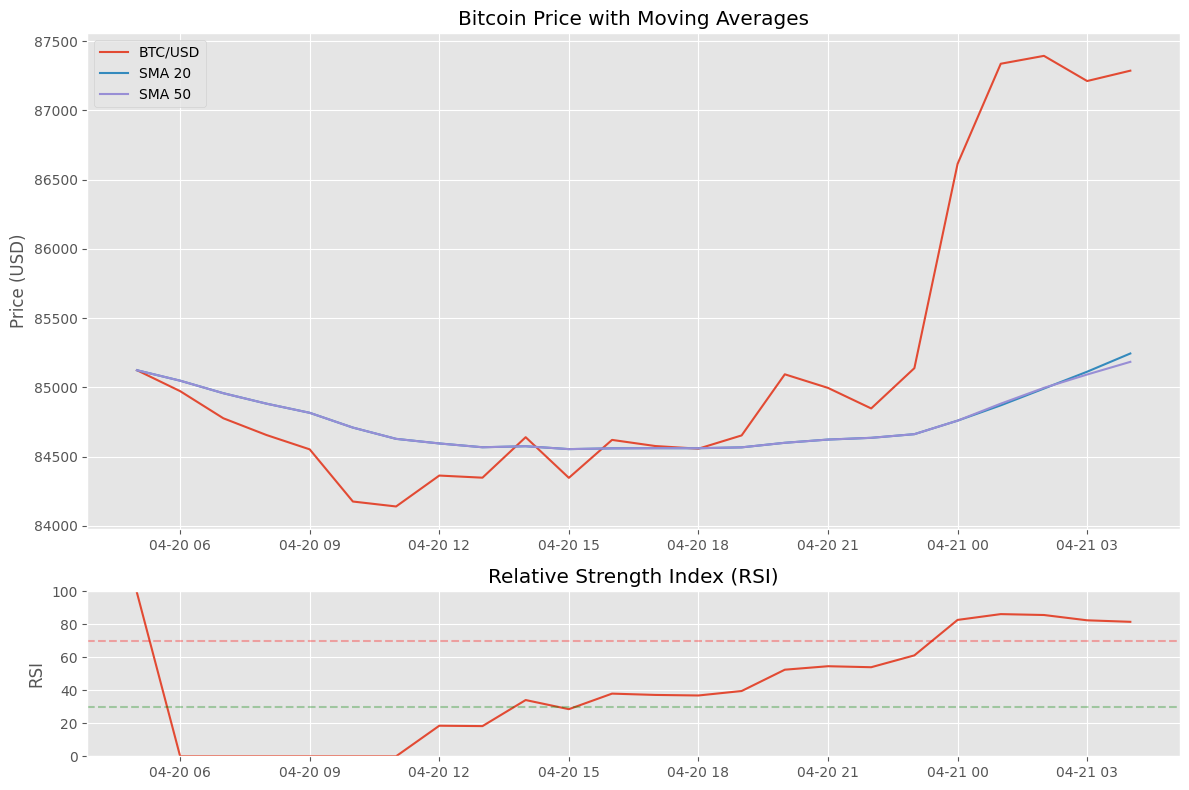

Latest Bitcoin Price: $87286.30
SMA 20: $85245.01
SMA 50: $85184.64
RSI: 81.38


In [8]:
# Fetch Bitcoin data
btc_data = get_historical_data('BTC/USD', ANALYSIS_INTERVAL, 100)  # Get more data for better visualization

if not btc_data.empty:
    # Calculate indicators
    btc_data['sma_20'] = calculate_sma(btc_data, 20)
    btc_data['sma_50'] = calculate_sma(btc_data, 50)
    btc_data['rsi'] = calculate_rsi(btc_data)
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Price and moving averages
    ax1.plot(btc_data.index, btc_data['close'], label='BTC/USD')
    ax1.plot(btc_data.index, btc_data['sma_20'], label='SMA 20')
    ax1.plot(btc_data.index, btc_data['sma_50'], label='SMA 50')
    ax1.set_title('Bitcoin Price with Moving Averages')
    ax1.set_ylabel('Price (USD)')
    ax1.legend()
    ax1.grid(True)
    
    # RSI
    ax2.plot(btc_data.index, btc_data['rsi'])
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.3)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.3)
    ax2.set_title('Relative Strength Index (RSI)')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Display latest data
    latest = btc_data.iloc[-1]
    print(f"Latest Bitcoin Price: ${latest['close']:.2f}")
    print(f"SMA 20: ${latest['sma_20']:.2f}")
    print(f"SMA 50: ${latest['sma_50']:.2f}")
    print(f"RSI: {latest['rsi']:.2f}")
else:
    print("No data available for Bitcoin.")

## 8. Run Trading Analysis for All Cryptocurrencies: Sharing the Love
Why limit ourselves to Bitcoin? This section runs our market analysis function for all the cryptocurrencies in our list (currently BTC and ETH). It prints the results and simulates trades. Diversification isn’t just a buzzword—it’s a survival strategy.

In [9]:
print(f"Running analysis for cryptocurrencies: {', '.join(CRYPTOCURRENCIES)}")

for crypto in CRYPTOCURRENCIES:
    print(f"\nAnalyzing {crypto}...")
    action, price = analyze_market(crypto)
    print(f"Analysis result: {action.upper()} at ${price:.2f}")
    
    # Execute trade (simulation mode)
    execute_trade(crypto, action, price, simulate=True)

Running analysis for cryptocurrencies: BTC/USD, ETH/USD

Analyzing BTC/USD...
Analysis result: HOLD at $87286.30

Analyzing ETH/USD...
Analysis result: SELL at $1638.75
No position to sell for ETH/USD: 404 Client Error: Not Found for url: https://paper-api.alpaca.markets/v2/positions/ETH/USD


## 9. Run a Single Trading Cycle: Putting It All Together
This is the grand finale where everything comes together. We run a complete trading cycle, analyzing the market, executing trades, and logging the results. It’s like a symphony of data science and finance, with Python as the conductor.

In [10]:
def run_trading_cycle(simulate=True):
    """Run a complete trading cycle across all cryptocurrencies."""
    print(f"Starting trading cycle in {'SIMULATION' if simulate else 'LIVE'} mode")
    
    results = []
    for crypto in CRYPTOCURRENCIES:
        print(f"\nAnalyzing {crypto}...")
        action, price = analyze_market(crypto)
        print(f"Analysis result: {action.upper()} at ${price:.2f}")
        
        # Execute trade
        execute_trade(crypto, action, price, simulate=simulate)
        
        # Store result
        results.append({
            'symbol': crypto,
            'action': action,
            'price': price,
            'timestamp': datetime.now().isoformat()
        })
    
    print("\nTrading cycle completed!")
    return results

# Run a trading cycle (simulation mode)
results = run_trading_cycle(simulate=True)

Starting trading cycle in SIMULATION mode

Analyzing BTC/USD...
Analysis result: HOLD at $87286.30

Analyzing ETH/USD...
Analysis result: SELL at $1638.75
No position to sell for ETH/USD: 404 Client Error: Not Found for url: https://paper-api.alpaca.markets/v2/positions/ETH/USD

Trading cycle completed!


## Future Improvement Possibilities
While this notebook demonstrates a functional crypto trading bot, there’s always room for improvement. Here are some ideas to take this project to the next level (yes index is starting from 0, because why not):

#### Add more
Add more crypto currencies to the mix for a bigger pool. 
#### Advanced Technical Indicators
Add more sophisticated indicators like Bollinger Bands, MACD, or Stochastic Oscillator to refine trading signals.
Experiment with combining multiple indicators for a more robust strategy.
#### Machine Learning Integration
Train machine learning models (e.g., Random Forest, LSTM, or Reinforcement Learning) to predict price movements or generate trading signals.
Use Kaggle datasets to train and validate models for better generalization.
#### Backtesting Framework
Implement a backtesting module to evaluate the strategy on historical data.
Include performance metrics like Sharpe ratio, maximum drawdown, and cumulative returns.
#### Risk Management Enhancements
Introduce dynamic position sizing based on volatility or risk-adjusted returns.
Add trailing stop-loss functionality to lock in profits during favorable market conditions.
#### Multi-Asset Support
Expand the bot to support more cryptocurrencies or other asset classes like stocks or forex.
Allow users to dynamically customize the list of assets.
#### Real-Time Data Integration
Integrate real-time data feeds for live trading.
Use WebSocket APIs for faster price updates and decision-making.
#### Portfolio Optimization
Add portfolio optimization techniques to allocate capital across multiple assets based on risk and return.
Use methods like Modern Portfolio Theory (MPT) or Black-Litterman models.
#### Performance Dashboard
Create an interactive dashboard using libraries like Plotly or Dash to visualize portfolio performance, trade history, and market trends.
Include real-time updates for better insights.
#### Notifications and Alerts
Add email, SMS, or Telegram notifications for trade execution or significant market events.
Provide alerts for potential trading opportunities based on predefined conditions.
#### Integration with Other APIs
Integrate with other trading platforms or exchanges (e.g., Binance, Coinbase) to diversify trading options.
Use sentiment analysis APIs (e.g., Twitter or news sentiment) to incorporate market sentiment into trading decisions.
#### Parameter Optimization
Implement a grid search or genetic algorithm to optimize trading parameters like SMA periods, RSI thresholds, and stop-loss percentages.
Automate the process of finding the best-performing strategy.
#### Cloud Deployment
Deploy the bot on a cloud platform (e.g., AWS, Google Cloud, or Azure) for 24/7 operation.
Use serverless architecture or containerization (e.g., Docker) for scalability and reliability.
#### Community Collaboration
Open-source the project on GitHub to encourage contributions from the community.
Add detailed documentation and examples to make it easier for others to use and extend the bot.
#### Gamification
Add a simulation mode with gamified elements, such as leaderboards or achievements, to make learning algorithmic trading more engaging.
These enhancements can make the bot more powerful, versatile, and user-friendly, while also increasing its appeal for competitions or real-world applications.



## Conclusion: From Data to Decisions
This is a crypto trading bot that can analyze markets, calculate indicators, and execute trades (in simulation mode, for now). This notebook has demonstrated how to:

1. Fetch cryptocurrency data using the Alpaca API.
2. Calculate technical indicators (SMA, RSI).
3. Implement a simple trading strategy.
4. Execute trades (in simulation mode).

To use this in a live environment:

1. Set up Alpaca API credentials.
2. Run the cells sequentially to test the functionality.
3. Adjust the trading parameters as needed (play around).
4. When ready, run a trading cycle with simulate=False to place actual orders (This account is setup for paper money).

Good luck, and may all our trades always be in the green! 🚀